# **Libraries**

In [1]:
import warnings
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
warnings.filterwarnings('ignore')

# **Data Preparation**

## **Download Data**

In [3]:
# Because this data (train.txt) has 16k (2k required) text, i use it as main data and then split it to train and test
!wget --no-check-certificate https://raw.githubusercontent.com/zekhoi/dicoding-bpml/master/data/nlp/emotions.txt -O /tmp/data.txt

--2022-09-10 05:15:02--  https://raw.githubusercontent.com/zekhoi/dicoding-bpml/master/data/nlp/emotions.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1658616 (1.6M) [text/plain]
Saving to: ‘/tmp/data.txt’

/tmp/data.txt       100%[===================>]   1.58M  --.-KB/s    in 0.06s   

2022-09-10 05:15:02 (28.2 MB/s) - ‘/tmp/data.txt’ saved [1658616/1658616]



In [4]:
df = pd.read_csv("/tmp/data.txt", error_bad_lines=False, delimiter=";", names=["text","emotions"])
df

,text,emotions
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
15995,i just had a very brief time in the beanbag an...,sadness
15996,i am now turning and i feel pathetic that i am...,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and i...,anger


## **Initialize**

In [5]:
df["emotions"].value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: emotions, dtype: int64

In [6]:
emotions = pd.get_dummies(df.emotions)
df = pd.concat([df, emotions], axis = 1)
df = df.drop(columns = "emotions")
df

,text,anger,fear,joy,love,sadness,surprise
0,i didnt feel humiliated,0,0,0,0,1,0
1,i can go from feeling so hopeless to so damned...,0,0,0,0,1,0
2,im grabbing a minute to post i feel greedy wrong,1,0,0,0,0,0
3,i am ever feeling nostalgic about the fireplac...,0,0,0,1,0,0
4,i am feeling grouchy,1,0,0,0,0,0
...,...,...,...,...,...,...,...
15995,i just had a very brief time in the beanbag an...,0,0,0,0,1,0
15996,i am now turning and i feel pathetic that i am...,0,0,0,0,1,0
15997,i feel strong and good overall,0,0,1,0,0,0
15998,i feel like this was such a rude comment and i...,1,0,0,0,0,0


In [7]:
# Splitting data to X and Y
X = df["text"].values
y = df[["anger", "fear", "joy", "love", "sadness", "surprise"]].values

# Splitting data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# **Execute**

## **Tokenizing and Padding**

In [8]:
tokenizer = Tokenizer(num_words = 16000, oov_token = "-unknown-")
tokenizer.fit_on_texts(X_train)
num_words = len(tokenizer.word_index) + 1

tokenizer = Tokenizer(num_words = num_words, oov_token = "-unknown-")
tokenizer.fit_on_texts(X_train) 

train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences)

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences)

## **Model**

### **Callbacks**

In [9]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get("accuracy") > 0.9 and logs.get("val_accuracy") > 0.9):
      print("Target reached!")
      self.model.stop_training = True

callbacks = myCallback()

### **LSTM**

In [10]:
# Buiding LSTM Model
lstm_model = Sequential([
    tf.keras.layers.Embedding(input_dim = num_words, output_dim = 36),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(6, activation="softmax")
])
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 36)          485460    
                                                                 
 lstm (LSTM)                 (None, 64)                25856     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 6)                 198       
                                                                 
Total params: 530,170
Trainable params: 530,170
Non-trai

### **Training**

In [11]:
num_epochs = 30

lstm_model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
lstm_result = lstm_model.fit(train_padded, y_train, epochs = num_epochs, validation_data = (test_padded, y_test), verbose = 1)

Epoch 1/30
400/400 [==============================] - 33s 69ms/step - loss: 1.4238 - accuracy: 0.3913 - val_loss: 1.0770 - val_accuracy: 0.5763
Epoch 2/30
400/400 [==============================] - 19s 46ms/step - loss: 0.6728 - accuracy: 0.7216 - val_loss: 0.5896 - val_accuracy: 0.7806
Epoch 3/30
400/400 [==============================] - 18s 45ms/step - loss: 0.3019 - accuracy: 0.8932 - val_loss: 0.3985 - val_accuracy: 0.8784
Epoch 4/30
400/400 [==============================] - 18s 45ms/step - loss: 0.1435 - accuracy: 0.9519 - val_loss: 0.3830 - val_accuracy: 0.8891
Epoch 5/30
400/400 [==============================] - 18s 44ms/step - loss: 0.0999 - accuracy: 0.9679 - val_loss: 0.4392 - val_accuracy: 0.8831
Epoch 6/30
400/400 [==============================] - 19s 47ms/step - loss: 0.0799 - accuracy: 0.9735 - val_loss: 0.4513 - val_accuracy: 0.8844
Epoch 7/30
400/400 [==============================] - 19s 48ms/step - loss: 0.0711 - accuracy: 0.9780 - val_loss: 0.4292 - val_accuracy:

## **Result Plot**

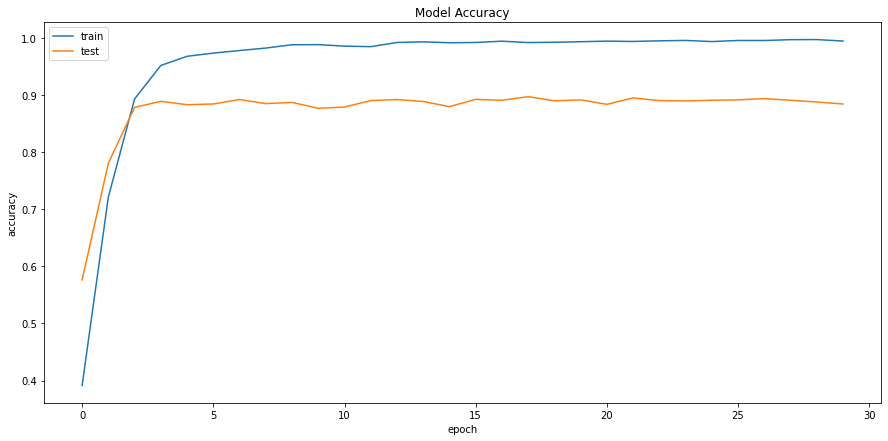

In [12]:
plt.figure(figsize=(15,7))
plt.plot(lstm_result.history["accuracy"])
plt.plot(lstm_result.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc = "upper left")
plt.show()

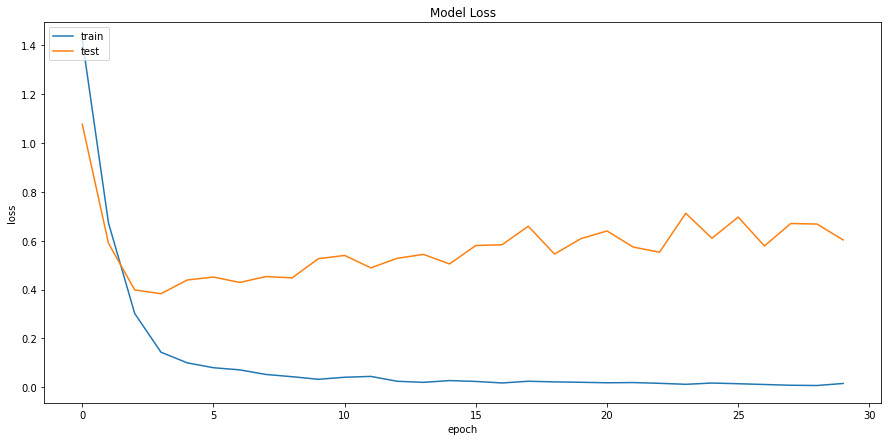

In [13]:
plt.figure(figsize = (15,7))
plt.plot(lstm_result.history["loss"])
plt.plot(lstm_result.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

## **Try**

In [14]:
# Try to predict random sentences
sentences = df["text"].sample(n = 5).values
le = LabelEncoder()
le.fit(["anger", "fear", "joy", "love", "sadness", "surprise"])

for sentence in sentences:
    print(sentence)
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence)
    result = le.inverse_transform(np.argmax(lstm_model.predict(sentence), axis = -1))[0]
    prob =  np.max(lstm_model.predict(sentence))
    print(f"{result} : {prob}\n\n")

i feel relieved that a rescue party has arrived
joy : 0.9999998807907104


i have been walking around feeling pissed off at the world lately
anger : 0.9999985694885254


i can feel the cold wind
anger : 0.9999724626541138


i feel like my dream of being a good guitarist and playing with other musicians was just a prideful dream
joy : 0.9999815225601196


i remember a couple of years ago i was feeling romantic and dreamy and asked him wonder if we ll celebrate our th anniversary
love : 0.9999810457229614


